# Laboratoire 1 : Extraction de primitives
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | NOMS - CODE PERMANENT                                   |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | SAISON ANNÉE                                            |
| Groupe                | X                                                       |
| Numéro du laboratoire | X                                                       |
| Professeur            | Prof. NOM                                               |
| Chargé de laboratoire | NOM                                                     |
| Date                  | DATE                                                    |

In [3]:
import numpy as np
import cv2
from sklearn import tree
from skimage import io
from PIL import Image
from core.feature_extraction.galaxy import galaxy_processor 

import random as rand
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'skimage'

In [ ]:
imgPath = "data/images/"
gp = galaxy_processor.GalaxyProcessor(imgPath)

galaxyDict = []
imgDict = []

# définition des classes
classes = ["smooth","spiral"]

# matrice x contenant toutes les images (nombre d'image, nombre de canaux(RGB), hauteur, largeur)
x = []

# matrice y contenant les étiquettes (nombre d'image, la classe)
y = []

# matrice primInfo contenant les informations voulues des images (nombre d'image, % ratio pixel blanc vs pixel noir, 
# ratio bleu rouge, différence de distance du point le plus brillant au 
# point noir le plus proche horizontallement et verticallement)
primInfo = []

# matrice contenant les images 
img_list = []

print("checkpoint 1")

with open("data/csv/galaxy/galaxy_label_data_set.csv") as fid:    # Execute la lecture du fichier et le ferme automatiqument apres la sortie du bloc de code
    fid.readline()
    next(fid)    # Skip la premiere ligne du fichier (id, classe)
    #for line in fid:
    for i in range(100):
        line = fid.read()
        # séparation des informations    
        currentLineInfo = line.split(',')

        # localiser l'image et obtenir les informations voulues
        img = io.imread(imgPath + currentLineInfo[0] + '.jpg')

        # obtenir les informations de l'image
        imgInformations = img.shape

        # ajouter les informations pertinentes aux listes
        x.append([currentLineInfo[0],imgInformations[2],imgInformations[0],imgInformations[1]])
        y.append([currentLineInfo[0],currentLineInfo[1].rstrip()])

        # sauvegarde de l'image dans la liste
        img_list.append(img)
    print("checkpoint 2")   
  

In [8]:
# compteur d'acces
pos = 0

print ("checkpoint 3")

# trouver les informations des primitives et les mettre dans la matrice des primitives
for img in img_list:
    #variables compteur
    compteurBlanc = 0
    compteurNoir = 0
    
    # Ratio
    
    # converti l'image en grayscale
    img_grayscale = np.array(Image.fromarray(img).convert('L'))
    
    # défini grace a numpi si un pixel doit être noir ou blanc dans le tableau
    black_white_array = np.asarray(img_grayscale).copy()
    black_white_array[black_white_array < 128] = 0
    black_white_array[black_white_array >= 128] = 255
    
    #compter combier des pixel blanc et noir sont dans l'image
    for pixelrow in black_white_array:
        for pixel in pixelrow:
            if pixel == 255:
                compteurBlanc += 1
            elif pixel == 0:
                compteurNoir += 1
    
    #calcule du % grâce au nombre de pixel blanc et noir
    centi = (compteurBlanc / (compteurBlanc + compteurNoir)) *100 
    
    # ratio bleu/rouge
    nbBleu = 0
    nbRouge = 0
    
    # on trouve le nombre de bleu
    bleuMini = np.array([155,0,0], np.uint8)
    bleuMax = np.array([255,50,50], np.uint8)
    
    newImageArray = cv2.inRange(img, bleuMini, bleuMax)
    nbBleu = cv2.countNonZero(newImageArray)
    
    # on trouve le nombre de rouge
    rougeMini = np.array([0,0,155], np.uint8)
    rougeMax = np.array([50,50,255], np.uint8)
    
    newImageArray = cv2.inRange(img, rougeMini, rougeMax)
    nbRouge = cv2.countNonZero(newImageArray)
    
    # création du ratio
    if(nbRouge != 0):
        RatioBleuRouge = nbBleu / nbRouge 
    elif(nbRouge == 0):
        if(nbBleu == 0):
            RatioBleuRouge = 1
        else:
            RatioBleuRouge = nbBleu
    
    # Distance
    distance = 0
    
    # trouver le point le plus brillant
    imgCopy = img
    grayScaleCopy = np.asarray(img_grayscale).copy()
    grayScaleCopy = cv2.GaussianBlur(grayScaleCopy,( 15, 15), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img_grayscale)
    cv2.circle(imgCopy, maxLoc, 15, (255, 0, 0), 2)
    
    # compteur vertical et horizontal
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    
    # loop verticallement et horizontalement
    while (compteurVert < x[pos][2] and distance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[maxLoc[0]][compteurVert] == 0):
            distance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurVert += 1
        
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    newDistance = 0
    
    while (compteurVert > 0 and newDistance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[maxLoc[0]][compteurVert] == 0):
            newDistance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurVert -= 1
    
    # regarder laquelle est la plus grande
    if distance < newDistance:
        distanceV = newDistance
    else:
        distanceV = distance
        
    #reset variables
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    newDistance = 0
    distance = 0
    
     # loop verticallement et horizontalement
    while (compteurHori < x[pos][3] and distance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[compteurHori][maxLoc[1]] == 0):
            distance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurHori += 1
        
    compteurVert = maxLoc[1]
    compteurHori = maxLoc[0]
    distanceCompteur = 0
    newDistance = 0
    
    while (compteurHori > 0 and newDistance == 0):
        
        #check + initialisation de la distance
        if(black_white_array[compteurHori][maxLoc[1]] == 0):
            newDistance = distanceCompteur
            
        #incrémentation
        distanceCompteur += 1
        compteurHori -= 1
        
    # regarder laquelle est la plus grande
    if distance < newDistance:
        distanceH = newDistance
    else:
        distanceH = distance
    
    '''
    # afficher le point le plus brillant comme vérification
    plt.imshow(imgCopy)
    plt.show()
    print(maxLoc)
    '''
    
    # calculer les distances horizontales et verticales vers le point le plus noir
    
    FinalDistance = abs(distanceH - distanceV)
    
    # sauvegarde des informations des primitives dans la liste
    primInfo.append([x[pos][0], RatioBleuRouge, FinalDistance])

    '''
    # printing test to see if all is right
    print(x[pos][0])
    print(RatioBleuRouge)
    print(FinalDistance)
    '''
    
    # incremantation du comteur
    pos  += 1
    
print ("checkpoint 4")

X = primInfo
Y = y[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

checkpoint 3


TypeError: '<' not supported between instances of 'int' and 'str'

ValueError: x and y must have same first dimension, but have shapes (1083,) and (1,)

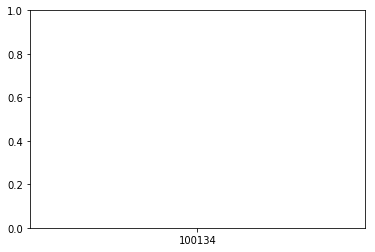

In [5]:
## Plot graphiques
# tracage des différent graphiques pour déterminer le pouvoir discriminent des primitives 
ratioPrimitive = []
bleuRougePrimitive = []
distancePrimitive = []

# on sépare le tableau principale pour montrer les primitives dans leur propre graphique
for infoLine in primInfo:
    ratioPrimitive.append(infoLine[0])
    bleuRougePrimitive.append(infoLine[1])
    distancePrimitive.append(infoLine[2])

x = ratioPrimitive 
y = 0 

plt.plot(x,y,'o')
plt.xlabel('Nombre')
plt.ylabel('Ratio(%)')
plt.title('Ratio blanc noir')
plt.grid(True)
plt.show()

x = bleuRougePrimitive
y = 0

plt.plot(x,y,'o')
plt.xlabel('Nombre')
plt.ylabel('Ratio')
plt.title('Ratio bleu rouge')
plt.grid(True)
plt.show()

x = distancePrimitive
y = 0

plt.plot(x,y,'o')
plt.xlabel('Nombre')
plt.ylabel('Distance')
plt.title('Distance de différence entre longeur verticale et horizontale')
plt.grid(True)
plt.show()



tree= DecisionTreeClassifier(max_depth = 0)
tree.fit(X_train_mod, Y_train_mod)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 2)
tree.fit(X_train_mod, Y_train_mod)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 3)
tree.fit(X_train_mod, Y_train_mod)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 4)
tree.fit(X_train_mod, Y_train_mod)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 5)
tree.fit(X_train_mod, Y_train_mod)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

tree= DecisionTreeClassifier(max_depth = 10)
tree.fit(X_train_mod, Y_train_mod)
Y_pred = tree.predict(X_test)
print(accuracy_score(Y_test, Y_pred))




Introduction et revue de la littérature

### Question 2

### Question 3

### Question 4

### Question 5

### Conclusion

### Bibliographie